# Project Description

In this project, I will analyze tabular data pertaining to startups that operated from 1980 to 2018, with the objective of predicting which startups are likely to continue their operations and which may close. 

The primary goal is to develop a robust machine learning model capable of assessing startup viability. 
Additionally, we I conduct a comprehensive exploratory analysis to uncover valuable insights and formulate recommendations for future founders regarding the key factors that influence startup success.

# 00 Imports

In [165]:
# Imports
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import f1_score, make_scorer

from phik import phik_matrix

In [166]:
# Float Format
pd.options.display.float_format = '{:,.2f}'.format

# 0 First Glance

In [167]:
dates = ['founded_at', 'first_funding_at', 'last_funding_at', 'closed_at']

df = pd.read_csv(
    '/Users/kseniagabrusevich/Desktop/01/ML/Kaggle/kaggle_startups_train_28062024.csv', 
    parse_dates=dates)

dates_test = ['first_funding_at', 'last_funding_at']

test = pd.read_csv(
    '/Users/kseniagabrusevich/Desktop/01/ML/Kaggle/kaggle_startups_test_28062024.csv',
    parse_dates=dates_test)

In [168]:
df.head()

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
0,Lunchgate,Online Reservations|Restaurants,"828,626.00",operating,CHE,25,Zurich,Zürich,2,2009-10-17,2011-05-01,2014-12-01,NaT
1,EarLens,Manufacturing|Medical|Medical Devices,"42,935,019.00",operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,NaT
2,Reviva Pharmaceuticals,Biotechnology,"35,456,381.00",operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,NaT
3,Sancilio and Company,Health Care,"22,250,000.00",operating,NaN,NaN,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,NaT
4,WireTough Cylinders,Manufacturing,NaN,operating,USA,VA,VA - Other,Bristol,1,2010-05-12,2012-02-01,2012-02-01,NaT


In [169]:
test.head()

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime
0,Crystalsol,Clean Technology,"2,819,200.00",NIC,17,NaN,NaN,1,2009-07-01,2009-07-01,3501
1,JBI Fish & Wings,Hospitality,NaN,USA,TN,TN - Other,Humboldt,1,2010-07-28,2010-07-28,2717
2,COINPLUS,Finance,"428,257.00",LUX,3,Esch-sur-alzette,Esch-sur-alzette,2,2014-05-15,2014-09-18,1295
3,Imagine Communications,Software|Video|Video Streaming,"34,700,000.00",USA,CA,San Diego,San Diego,4,2005-01-01,2010-04-20,4748
4,DNA13,Software,"4,530,000.00",CAN,ON,Ottawa,Ottawa,1,2007-05-08,2007-05-08,6209


# 1. EDA

## 1.1 Overview

In [170]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               52515 non-null  object        
 1   category_list      50051 non-null  object        
 2   funding_total_usd  42447 non-null  float64       
 3   status             52516 non-null  object        
 4   country_code       47014 non-null  object        
 5   state_code         45753 non-null  object        
 6   region             46157 non-null  object        
 7   city               46157 non-null  object        
 8   funding_rounds     52516 non-null  int64         
 9   founded_at         52516 non-null  datetime64[ns]
 10  first_funding_at   52516 non-null  datetime64[ns]
 11  last_funding_at    52516 non-null  datetime64[ns]
 12  closed_at          4917 non-null   datetime64[ns]
dtypes: datetime64[ns](4), float64(1), int64(1), object(7)
memory 

In [171]:
# Missing values in train
df.isna().mean()

name                0.00
category_list       0.05
funding_total_usd   0.19
status              0.00
country_code        0.10
state_code          0.13
region              0.12
city                0.12
funding_rounds      0.00
founded_at          0.00
first_funding_at    0.00
last_funding_at     0.00
closed_at           0.91
dtype: float64

In [172]:
# Missing values in test
test.isna().mean()

name                0.00
category_list       0.05
funding_total_usd   0.20
country_code        0.11
state_code          0.13
region              0.12
city                0.12
funding_rounds      0.00
first_funding_at    0.00
last_funding_at     0.00
lifetime            0.00
dtype: float64

- There are 5 features which have missing values. This will be dealt with further on.

## 1.2 Target Overview

In [173]:
df.status.value_counts(normalize=True)

status
operating   0.91
closed      0.09
Name: proportion, dtype: float64

- This indicates a class imbalance which may impact model performance, particularly while using F1 score as the metric, as the model may be biased towards predicting the majority class ("operating"). 

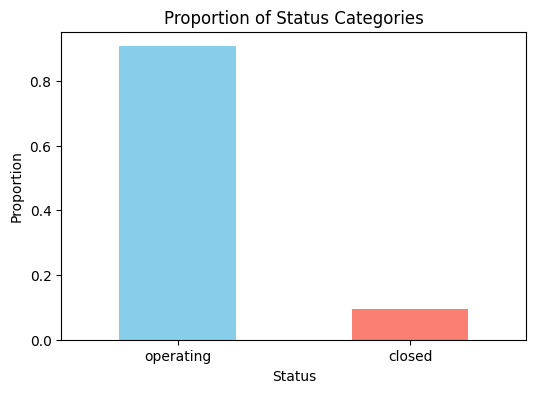

In [174]:
# Visualization of the class imbalance

status_counts = df['status'].value_counts(normalize=True)
plt.figure(figsize=(6, 4))
status_counts.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Proportion of Status Categories')
plt.xlabel('Status')
plt.ylabel('Proportion')
plt.xticks(rotation=0)
plt.show()

- For this case, since the status column is imbalanced setting auto_class_weights="SqrtBalanced" would help CatBoost assign more weight to the minority class.

## 1.3 Category_list

In [175]:
# Missing values
df['category_list'].isna().mean()

0.04693807601492878

In [176]:
# Fill the missing values with 'Unknown'
df['category_list'] = df['category_list'].fillna('Unknown')
test['category_list'] = test['category_list'].fillna('Unknown')

In [177]:
# Unique values
df['category_list'].nunique()

22106

In [178]:
cat_names = df['category_list'].str.get_dummies(sep='|')

In [179]:
cat_names.shape

(52516, 855)

In [180]:
# Most popular categories (Top-10)
cat_names.sum().sort_values(ascending=False).head(10)

Software               7017
Mobile                 4399
Biotechnology          3668
E-Commerce             3308
Unknown                2465
Curated Web            2407
Social Media           2284
Enterprise Software    2193
Advertising            1985
Health Care            1885
dtype: int64

In [181]:
def replace_rare_categories(df, column_name, threshold=0.01):
    """
    Replaces rare categories in the specified column with 'Other'.

    Parameters:
    - df: DataFrame containing the data.
    - column_name: The name of the column containing categories.
    - threshold: Proportion below which categories are considered rare (default: 0.01 for 1%).

    Returns:
    - DataFrame with a new column 'category_list_new' having rare categories replaced.
    """

    category_counts = df[column_name].str.split('|').explode().value_counts(normalize=True)

    rare_categories = category_counts[category_counts < threshold].index

    df['category_list_new'] = df[column_name].apply(
        lambda x: '|'.join(['Other' if cat in rare_categories else cat for cat in x.split('|')])
    )
    
    new_category_counts = df['category_list_new'].str.split('|').explode().value_counts(normalize=True)
    print(new_category_counts)

    return df

In [182]:
# Replace rare categories in the training dataset
df_train = replace_rare_categories(df, 'category_list', threshold=0.01)

# Replace rare categories in the test dataset
df_test = replace_rare_categories(test, 'category_list', threshold=0.01)

category_list_new
Other                 0.63
Software              0.06
Mobile                0.04
Biotechnology         0.03
E-Commerce            0.03
Unknown               0.02
Curated Web           0.02
Social Media          0.02
Enterprise Software   0.02
Advertising           0.02
Health Care           0.02
Games                 0.01
Internet              0.01
SaaS                  0.01
Health and Wellness   0.01
Education             0.01
Analytics             0.01
Apps                  0.01
Finance               0.01
Technology            0.01
Name: proportion, dtype: float64
category_list_new
Other                 0.62
Software              0.06
Mobile                0.04
Biotechnology         0.03
E-Commerce            0.03
Curated Web           0.02
Social Media          0.02
Unknown               0.02
Enterprise Software   0.02
Health Care           0.02
Advertising           0.02
Games                 0.02
Education             0.01
Health and Wellness   0.01
Internet     

## 1.3 Funding Total

In [183]:
# Missing values
df.funding_total_usd.isna().mean()

0.19173204356767462

In [184]:
df[df['funding_total_usd'].isna()]['funding_rounds'].mean()

1.1140133081736021

In [185]:
# Fill missing values in the funding_total_usd column based on the median of each group defined by funding_rounds.

df['funding_total_usd'] = df.groupby('funding_rounds')['funding_total_usd'].transform(lambda x: x.fillna(x.median()))
test['funding_total_usd'] = test.groupby('funding_rounds')['funding_total_usd'].transform(lambda x: x.fillna(x.median()))

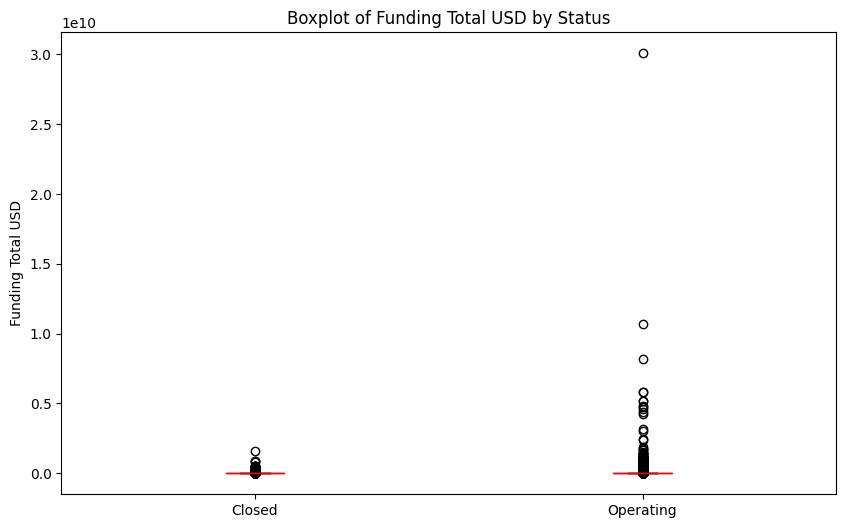

In [233]:
closed_funding = df[df['status'] == 'closed']['funding_total_usd']
operating_funding = df[df['status'] == 'operating']['funding_total_usd']

data = [closed_funding, operating_funding]


plt.figure(figsize=(10, 6))
plt.boxplot(data, labels=['Closed', 'Operating'], patch_artist=True,
            boxprops=dict(facecolor='lightcoral'), 
            medianprops=dict(color='red'))


plt.title('Boxplot of Funding Total USD by Status')
plt.ylabel('Funding Total USD')
plt.show()

In [242]:
df[df['status']=='closed'][['funding_total_usd']].describe().T

,count,mean,std,min,25%,50%,75%,max
funding_total_usd,"4,917.00","9,158,092.39","41,853,766.37",2.00,"370,000.00","860,000.00","5,000,000.00","1,567,504,319.00"


In [244]:
df[df['status']=='operating'][['funding_total_usd']].describe().T

,count,mean,std,min,25%,50%,75%,max
funding_total_usd,"47,599.00","15,579,334.03","176,320,465.55",1.00,"560,000.00","1,100,000.00","7,200,000.00","30,079,503,000.00"


## 1.4 Features describing location

In [186]:
# Define a list of geographical columns (geo)
geo = ['country_code', 'state_code', 'region', 'city']

In [187]:
# Fill missing values
df[geo] = df[geo].fillna('Missing')
test[geo] = test[geo].fillna('Missing')

In [188]:
# Unique values
for col in df[geo]:
    print(df[col].nunique())

135
301
1037
4478


- Having too many unique values can slow down the learning process. Fortunately, CatBoost effectively manages categorical features with target-based encoding.

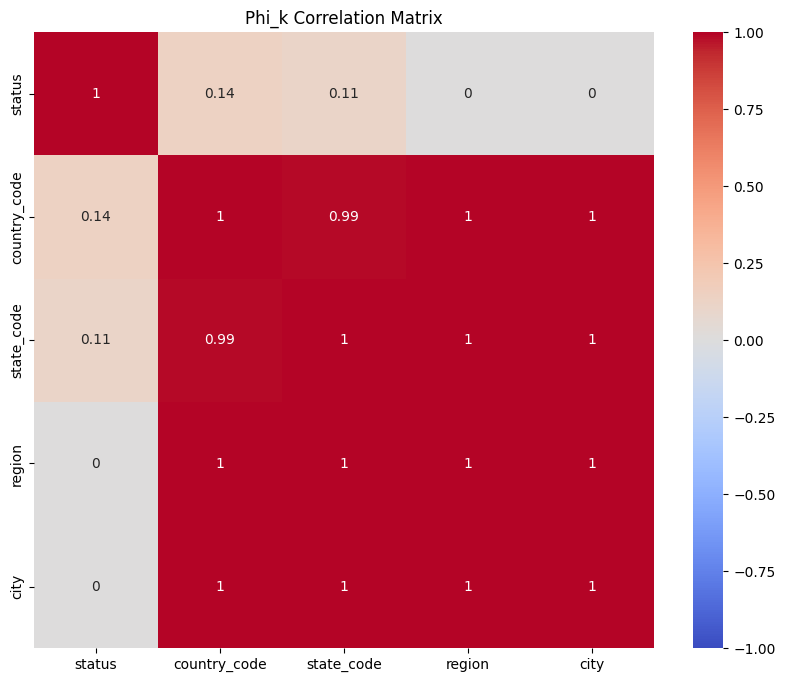

In [189]:
# Check for multicollinearity

_df = df[['status']+ geo].sample(1000)
matrix = _df.phik_matrix()

plt.figure(figsize=(10, 8))
sns.heatmap(matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Phi_k Correlation Matrix')
plt.show()

- Since all geographic features are highly correlated with each other, only one should be used in the model. 
- However, all geographic features show similar correlation with the target which is why it's hard to say which one will be more predictive. 
- The feature will be selected during the modelling process.

## 1.5 Funding Rounds

In [221]:
df['funding_rounds'].value_counts(normalize=True)

funding_rounds
1    0.64
2    0.19
3    0.08
4    0.04
5    0.02
6    0.01
7    0.01
8    0.00
9    0.00
10   0.00
11   0.00
12   0.00
13   0.00
16   0.00
15   0.00
14   0.00
17   0.00
18   0.00
19   0.00
Name: proportion, dtype: float64

In [246]:
df.groupby('status')['funding_rounds'].agg(['min', 'max', 'mean'])

,min,max,mean
status,,,
closed,1,11,1.40
operating,1,19,1.78


- Not much of a difference. Perhaps this is an unimportant feature.

## 1.6 Dates

In [190]:
df[dates].describe()

,founded_at,first_funding_at,last_funding_at,closed_at
count,52516,52516,52516,4917
mean,2008-11-04 09:44:16.196206848,2011-07-17 04:45:33.247010304,2012-06-27 16:29:42.313961472,2012-01-16 16:14:21.012812544
min,1970-02-05 00:00:00,1977-05-15 00:00:00,1977-05-15 00:00:00,1983-10-06 00:00:00
25%,2006-10-01 00:00:00,2009-10-12 00:00:00,2011-02-01 00:00:00,2009-09-18 00:00:00
50%,2010-10-01 00:00:00,2012-07-23 00:00:00,2013-08-30 00:00:00,2012-09-15 00:00:00
75%,2013-01-01 00:00:00,2014-04-01 00:00:00,2014-11-17 00:00:00,2015-04-23 00:00:00
max,2016-04-02 00:00:00,2015-12-05 00:00:00,2015-12-07 00:00:00,2017-10-21 00:00:00


In [191]:
# Check if the number of NaN values in the closed_at column is equal to the number of rows where the status column is 'operating'.
if df['closed_at'].isna().sum() == (df['status']=='operating').sum():
    print('Data is consistent: all companies marked as "operating" indeed have no closed_at date.')
else:
    print('Data inconsistency found: there are discrepancies between the status and closed_at date.')

Data is consistent: all companies marked as "operating" indeed have no closed_at date.


In [192]:
# Replace NaT in 'closed_at' with '2018-01-01'
df['closed_at'] = df['closed_at'].fillna(pd.to_datetime('2018-01-01'))

# 2 Feature Engineering

In [193]:
# Calculate 'lifetime' as the difference between 'closed_at' and 'founded_at'
df['lifetime'] = (df['closed_at'] - df['founded_at']).dt.days

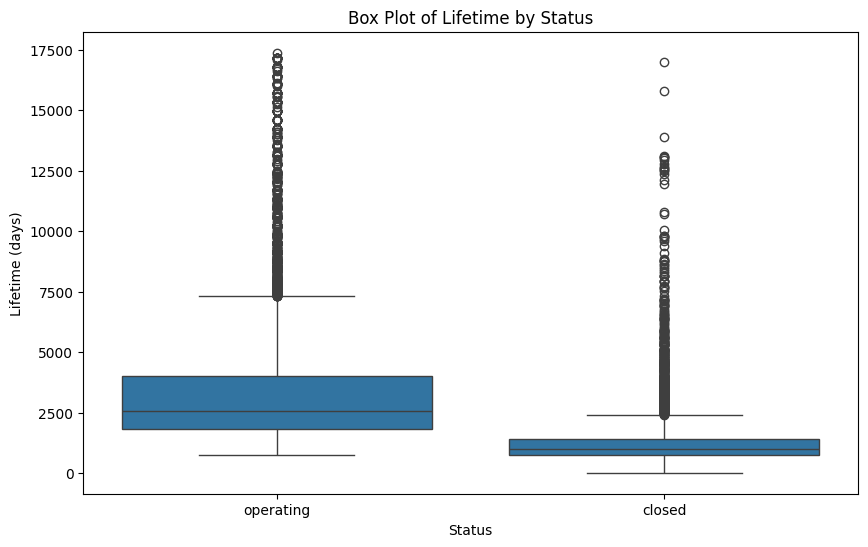

In [194]:
plt.figure(figsize=(10, 6))

# Box plot of lifetime for each status
sns.boxplot(x='status', y='lifetime', data=df)

plt.title("Box Plot of Lifetime by Status")
plt.xlabel("Status")
plt.ylabel("Lifetime (days)")

plt.show()

In [195]:
# Calculate 'funding_duration' as the difference between 'last_funding_at' and 'first_funding_at'
df['funding_duration'] = (df['last_funding_at'] - df['first_funding_at']).dt.days
test['funding_duration'] = (test['last_funding_at'] - test['first_funding_at']).dt.days

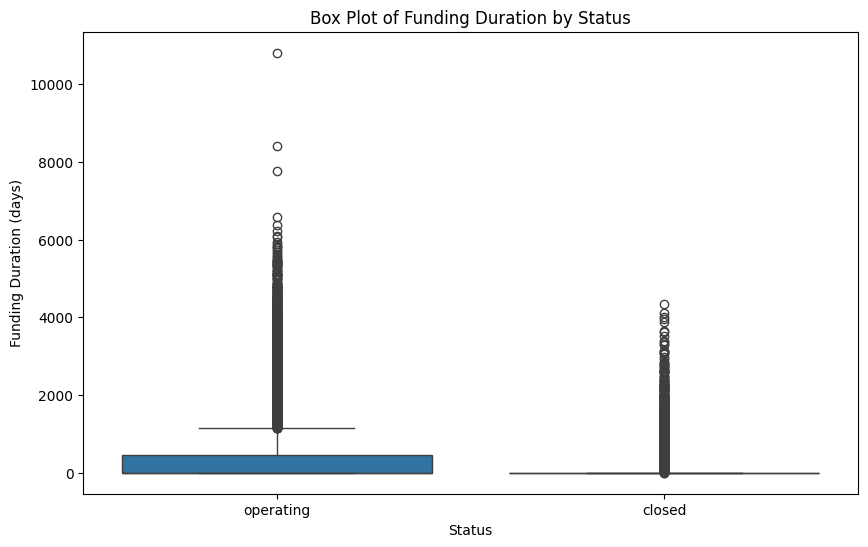

In [196]:
plt.figure(figsize=(10, 6))

# Box plot of lifetime for each status
sns.boxplot(x='status', y='funding_duration', data=df)

plt.title("Box Plot of Funding Duration by Status")
plt.xlabel("Status")
plt.ylabel("Funding Duration (days)")

plt.show()

In [197]:
def extract_day_month_year(df, column_name):
    """
    Extracts the day, month, and year from a datetime column in a DataFrame.
    
    Parameters:
    df (pd.DataFrame): The DataFrame containing the datetime column.
    column_name (str): The name of the datetime column from which to extract the day, month, and year.
    
    Returns:
    None: The function modifies the DataFrame in place by adding three new columns.
    """
    
    df[column_name + '_day'] = df[column_name].dt.day
    df[column_name + '_month'] = df[column_name].dt.month
    df[column_name + '_year'] = df[column_name].dt.year

In [198]:
# Extract day, month, year from dates columns in train
for col in df[dates_test]:
    extract_day_month_year(df, col)

In [199]:
# Extract day, month, year from dates columns in test
for col in test[dates_test]:
    extract_day_month_year(test, col)

In [200]:
df.head()

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,...,closed_at,category_list_new,lifetime,funding_duration,first_funding_at_day,first_funding_at_month,first_funding_at_year,last_funding_at_day,last_funding_at_month,last_funding_at_year
0,Lunchgate,Online Reservations|Restaurants,"828,626.00",operating,CHE,25,Zurich,Zürich,2,2009-10-17,...,2018-01-01,Other|Other,2998,1310,1,5,2011,1,12,2014
1,EarLens,Manufacturing|Medical|Medical Devices,"42,935,019.00",operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,...,2018-01-01,Other|Other|Other,4748,1393,4,5,2010,25,2,2014
2,Reviva Pharmaceuticals,Biotechnology,"35,456,381.00",operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,...,2018-01-01,Biotechnology,4383,681,20,8,2012,2,7,2014
3,Sancilio and Company,Health Care,"22,250,000.00",operating,Missing,Missing,Missing,Missing,3,2004-01-01,...,2018-01-01,Health Care,5114,1051,1,9,2011,18,7,2014
4,WireTough Cylinders,Manufacturing,"860,000.00",operating,USA,VA,VA - Other,Bristol,1,2010-05-12,...,2018-01-01,Other,2791,0,1,2,2012,1,2,2012


# 3 Correlation of numeric data

In [201]:
# Numeric values
num_cols = [col for col in df.columns if df[col].dtype in ['int64', 'int32', 'float64']]
num_cols

['funding_total_usd',
 'funding_rounds',
 'lifetime',
 'funding_duration',
 'first_funding_at_day',
 'first_funding_at_month',
 'first_funding_at_year',
 'last_funding_at_day',
 'last_funding_at_month',
 'last_funding_at_year']

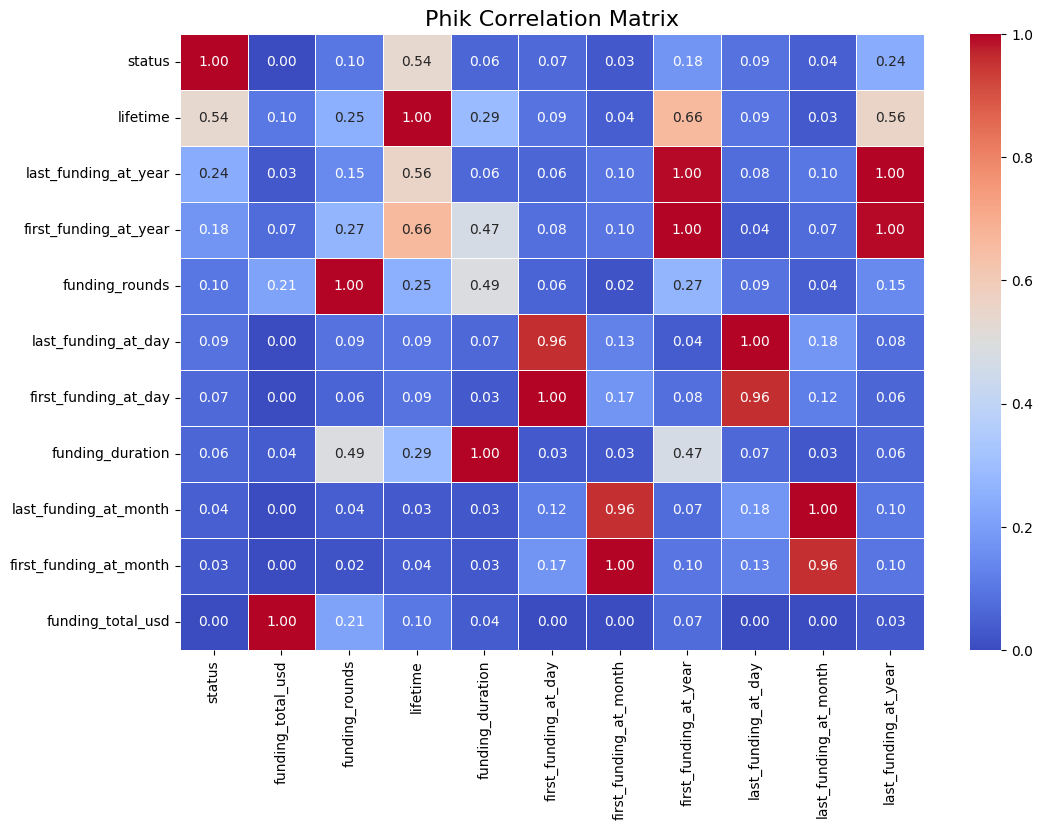

In [202]:
# Calculate phik correlation
_df = df[['status'] + num_cols]
_matrix = _df.phik_matrix(interval_cols=num_cols).sort_values(by='status', ascending=False)

# Plot Correlation Matrix
plt.figure(figsize=(12, 8))
sns.heatmap(_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Phik Correlation Matrix', fontsize=16)
plt.show()

- Lifetime shows a strong correlation with the target variable.
- As the first and last funding years/days/months are highly correlated with each other, only one of them will be retained for further modeling.
- While the other features demonstrate lower correlations, the significance of all features will be evaluated by CatBoost in the later stages of the modeling process.

# 4 Model

In [203]:
df.columns

Index(['name', 'category_list', 'funding_total_usd', 'status', 'country_code',
       'state_code', 'region', 'city', 'funding_rounds', 'founded_at',
       'first_funding_at', 'last_funding_at', 'closed_at', 'category_list_new',
       'lifetime', 'funding_duration', 'first_funding_at_day',
       'first_funding_at_month', 'first_funding_at_year',
       'last_funding_at_day', 'last_funding_at_month', 'last_funding_at_year'],
      dtype='object')

In [204]:
# Baseline model with full list of features

cat_features = ['category_list', 'category_list_new', 'country_code', 'state_code', 'region', 'city']

X = df.drop(columns=['name', 'status', 'founded_at', 'closed_at'])
y = df['status']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


clf = CatBoostClassifier(thread_count=-1, random_seed=42, cat_features=cat_features)

clf.fit(
    X_train,
    y_train,
    eval_set=(X_val, y_val),
    verbose=200,
    use_best_model=True,
    plot=False,
    early_stopping_rounds=100
)

Learning rate set to 0.079778
0:	learn: 0.5626213	test: 0.5615096	best: 0.5615096 (0)	total: 97.1ms	remaining: 1m 37s
200:	learn: 0.0714401	test: 0.0684176	best: 0.0684176 (200)	total: 5.4s	remaining: 21.5s
400:	learn: 0.0603828	test: 0.0659479	best: 0.0659238 (398)	total: 10.5s	remaining: 15.7s
600:	learn: 0.0532640	test: 0.0648696	best: 0.0648081 (589)	total: 15.3s	remaining: 10.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.06450449611
bestIteration = 659

Shrink model to first 660 iterations.


In [205]:
# Output feature importance to understand which features are driving the predictions
clf.get_feature_importance(prettified=True)

,Feature Id,Importances
0,lifetime,36.27
1,first_funding_at,12.71
2,last_funding_at,10.34
3,funding_total_usd,6.00
4,category_list,4.39
5,country_code,4.16
6,first_funding_at_year,4.13
7,category_list_new,2.87
8,first_funding_at_day,2.68
9,last_funding_at_year,2.66


In [206]:
selected_features = [
    'lifetime',
    'first_funding_at',
    'last_funding_at',
    'funding_total_usd',
    'category_list_new',
    'region',
    'first_funding_at_day',
    'funding_duration'
]
X = df[selected_features]

cat_features=['category_list_new', 'region']
# Training and tuning

dataset = Pool(X, label=y, cat_features=cat_features)

clf = CatBoostClassifier(
    auto_class_weights='SqrtBalanced',
    random_seed=123,
    verbose=0,  # Set to 0 to suppress the output
    eval_metric='F1'  # Specify F1 as the evaluation metric
)

# Parameter grid
param_grid = {
    'depth': [4, 6],
    'learning_rate': [0.03, 0.06, 0.1],
    'iterations': [1000, 2000, 3500],
    'early_stopping_rounds': [50]
}

# Perform the grid search with F1 as the evaluation metric
grid_search_result = clf.grid_search(
    param_grid,
    dataset,
    cv=5,
    stratified=True, 
    partition_random_seed=123,
    refit=True  
)

# Print the best parameters and the corresponding score
print("Best Parameters:", grid_search_result['params'])

Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9721394614
bestIteration = 455

0:	loss: 0.9721395	best: 0.9721395 (0)	total: 9.03s	remaining: 2m 33s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9726066626
bestIteration = 356

1:	loss: 0.9726067	best: 0.9726067 (1)	total: 14.6s	remaining: 1m 56s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9735346226
bestIteration = 411

2:	loss: 0.9735346	best: 0.9735346 (2)	total: 20.4s	remaining: 1m 41s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9721394614
bestIteration = 455

3:	loss: 0.9721395	best: 0.9735346 (2)	total: 26.4s	remaining: 1m 32s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9726066626
bestIteration = 356

4:	loss: 0.9726067	best: 0.9735346 (2)	total: 31.6s	remaining: 1m 22s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9735346226
bestIteration = 411

5:	loss: 0.9735346	best: 0.9735346 (2)	total: 37.3

# 5. Predictions

In [207]:
# Test data with the same features as the training data
X_test = test[selected_features]

# Pool for test data
test_pool = Pool(data=X_test, cat_features=cat_features)

# Predictions using the trained CatBoost model
predictions = clf.predict(test_pool)

predictions

array(['operating', 'operating', 'operating', ..., 'operating',
       'operating', 'operating'], dtype=object)

In [208]:
test['status'] = predictions
test.head()

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime,category_list_new,funding_duration,first_funding_at_day,first_funding_at_month,first_funding_at_year,last_funding_at_day,last_funding_at_month,last_funding_at_year,status
0,Crystalsol,Clean Technology,"2,819,200.00",NIC,17,Missing,Missing,1,2009-07-01,2009-07-01,3501,Clean Technology,0,1,7,2009,1,7,2009,operating
1,JBI Fish & Wings,Hospitality,"884,185.79",USA,TN,TN - Other,Humboldt,1,2010-07-28,2010-07-28,2717,Other,0,28,7,2010,28,7,2010,operating
2,COINPLUS,Finance,"428,257.00",LUX,3,Esch-sur-alzette,Esch-sur-alzette,2,2014-05-15,2014-09-18,1295,Finance,126,15,5,2014,18,9,2014,operating
3,Imagine Communications,Software|Video|Video Streaming,"34,700,000.00",USA,CA,San Diego,San Diego,4,2005-01-01,2010-04-20,4748,Software|Other|Other,1935,1,1,2005,20,4,2010,operating
4,DNA13,Software,"4,530,000.00",CAN,ON,Ottawa,Ottawa,1,2007-05-08,2007-05-08,6209,Software,0,8,5,2007,8,5,2007,operating


In [209]:
submission = test[['name', 'status']]

In [210]:
submission.head()

,name,status
0,Crystalsol,operating
1,JBI Fish & Wings,operating
2,COINPLUS,operating
3,Imagine Communications,operating
4,DNA13,operating


In [211]:
submission.to_csv('predictions_11_.csv', index=False)

f1 on test = 0.884

In [212]:
# Generate another feature
df['ref_date'] = pd.to_datetime('2018-01-01')
df['first_funding_to_ref_date'] = (df['ref_date'] - df['first_funding_at']).dt.days
test['ref_date'] = pd.to_datetime('2018-01-01')
test['first_funding_to_ref_date'] = (test['ref_date'] - test['first_funding_at']).dt.days

In [213]:
selected_features = [
    'lifetime',
    'first_funding_at',
    'last_funding_at',
    'funding_total_usd',
    'category_list_new',
    'region',
    #'city',
    #'first_funding_at_year',
    'first_funding_at_day',
    'funding_duration',
    'first_funding_to_ref_date'
]
X = df[selected_features]

cat_features=['category_list_new', 'region']
# Training and tuning

dataset = Pool(X, label=y, cat_features=cat_features)

clf = CatBoostClassifier(
    auto_class_weights='SqrtBalanced',
    random_seed=123,
    verbose=0,  # Set to 0 to suppress the output
    eval_metric='F1'  # Specify F1 as the evaluation metric
)

# Parameter grid
param_grid = {
    'depth': [4, 6],
    'learning_rate': [0.03, 0.06, 0.1],
    'iterations': [1000, 2000, 3500],
    'early_stopping_rounds': [50]
}

# Perform the grid search with F1 as the evaluation metric
grid_search_result = clf.grid_search(
    param_grid,
    dataset,
    cv=5,
    stratified=True, 
    partition_random_seed=123,
    refit=True  
)

# Print the best parameters and the corresponding score
print("Best Parameters:", grid_search_result['params'])

Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9713154695
bestIteration = 249

0:	loss: 0.9713155	best: 0.9713155 (0)	total: 3.77s	remaining: 1m 4s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9709981725
bestIteration = 116

1:	loss: 0.9709982	best: 0.9713155 (0)	total: 6.09s	remaining: 48.8s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9714643265
bestIteration = 110

2:	loss: 0.9714643	best: 0.9714643 (2)	total: 8.21s	remaining: 41.1s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9713154695
bestIteration = 249

3:	loss: 0.9713155	best: 0.9714643 (2)	total: 12.2s	remaining: 42.6s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9709981725
bestIteration = 116

4:	loss: 0.9709982	best: 0.9714643 (2)	total: 14.4s	remaining: 37.5s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9714643265
bestIteration = 110

5:	loss: 0.9714643	best: 0.9714643 (2)	total: 16.6s	rem

In [150]:
# Test data with the same features as the training data
X_test = test[selected_features]

# Pool for test data
test_pool = Pool(data=X_test, cat_features=cat_features)

# Predictions using the trained CatBoost model
predictions = clf.predict(test_pool)

test['status'] = predictions
submission = test[['name', 'status']]
submission.to_csv('predictions_11_.csv', index=False)

f1 on test = 0.88540

# 6. Feature Importance

                     Feature  Importance
0                   lifetime       40.23
2            last_funding_at       10.81
3          funding_total_usd        8.70
5                     region        8.64
1           first_funding_at        8.40
8  first_funding_to_ref_date        7.67
4          category_list_new        7.47
6       first_funding_at_day        4.74
7           funding_duration        3.35


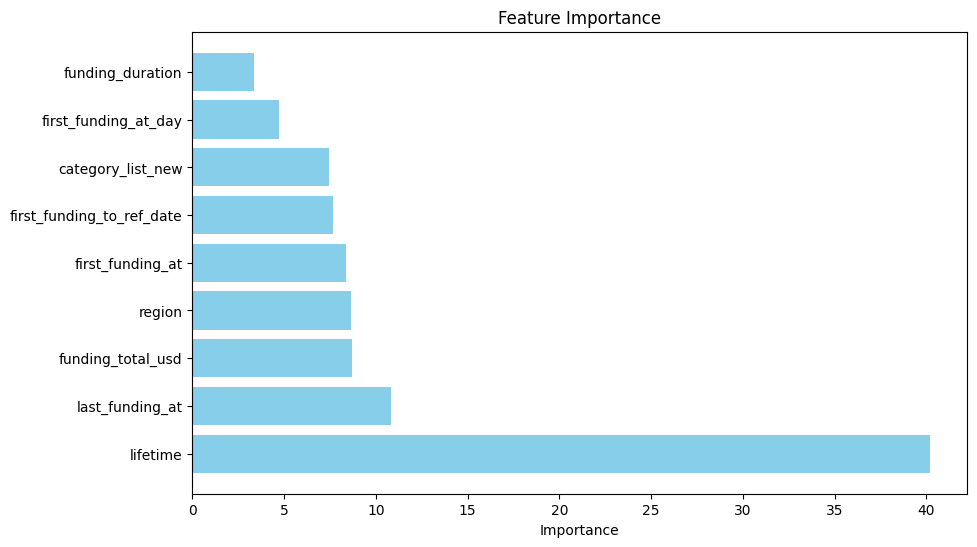

In [217]:
feature_importances = clf.get_feature_importance()

importance_df = pd.DataFrame({
    'Feature': selected_features,
    'Importance': feature_importances
})

importance_df = importance_df.sort_values(by='Importance', ascending=False)

print(importance_df)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.show()

# 7. Conclusion

In this study, I developed a machine learning model using CatBoost to predict startup closures. The model proved to be highly effective, achieving an impressive F1 score of 0.88.

My analysis of feature importance revealed that key factors influencing a startup's success include stable funding, the date of last funding, and the region. 

The results of this research can be valuable for investors and entrepreneurs looking to assess risks and make informed decisions. By focusing on startups with a lifetime exceeding 2 years, the model offers unique insights into long-term potential.

Looking ahead, we suggest several avenues for further research:

- Incorporating additional data, especially more recent information (including new data post-2018).
- Exploring other machine learning models and ensemble methods.
- Framing the problem as a time series analysis (e.g., "How long will the startup survive?" or "Will the startup close within the next n years?").
